<a href="https://colab.research.google.com/github/Tonyjoyy/trading_strategy/blob/main/ETF_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import re
import matplotlib.pyplot as plt

def download_data(symbol, start_date, end_date):
    return yf.download(symbol, start=start_date, end=end_date)

def calculate_rsi(prices, window):
    delta = prices.diff(1)
    gain = delta.clip(lower=0).rolling(window=window).mean()
    loss = -delta.clip(upper=0).rolling(window=window).mean()
    rs = gain / loss.replace(0, np.finfo(float).eps)  # Avoid division by zero
    return 100 - (100 / (1 + rs))

def sanitize_feature_names(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '', str(col)) for col in df.columns]
    return df


def compute_features(data_etf, data_sp500):
    # Reset index to flatten the multi-index structure
    data_etf = data_etf.reset_index()
    data_sp500 = data_sp500.reset_index()

    # Use 'Close' instead of 'Adj Close' (check for column existence)
    if 'Close' not in data_etf.columns or 'Close' not in data_sp500.columns:
        raise KeyError("The 'Close' column is missing in the downloaded data.")

    # Extract relevant columns
    df = data_etf[['Close']].rename(columns={"Close": "Price"}).copy()
    df['sp500price'] = data_sp500['Close']

    # Compute simple return features
    for i in range(1, 6):
        df[f'Return_{i}'] = df['Price'].pct_change(i)

    # Compute RSI
    df['RSI_6'] = calculate_rsi(df['Price'], 6)
    df['RSI_12'] = calculate_rsi(df['Price'], 12)
    df['RSI_24'] = calculate_rsi(df['Price'], 24)

    # Compute moving averages
    for ma in [20, 50, 100, 200]:
        df[f'MA{ma}_Price'] = df['Price'].rolling(window=ma).mean() / df['Price']
        df[f'MA{ma}_Bigger'] = (df['Price'].rolling(window=ma).mean() - df['Price']) / df['Price']

    # Compute SP500 features
    sp500_returns = data_sp500['Close'].pct_change()
    df['SP500_5Day_Mean_Return'] = sp500_returns.rolling(window=5).mean()

    # Compute MACD
    ema_short = df['Price'].ewm(span=12, adjust=False).mean()
    ema_long = df['Price'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_short - ema_long
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']

    # Compute new factors: highest and lowest prices
    df['High20_to_Price'] = df['Price'].rolling(window=20).max() / df['Price']
    df['Low20_to_Price'] = df['Price'].rolling(window=20).min() / df['Price']
    df['High5_to_Price'] = df['Price'].rolling(window=5).max() / df['Price']
    df['Low5_to_Price'] = df['Price'].rolling(window=5).min() / df['Price']

    # Sanitize feature names
    df = sanitize_feature_names(df)


    return df.dropna()

In [78]:
start_date, end_date = "2017-01-01", "2025-01-01"
etf_symbol, sp500_symbol = "XLF", "^GSPC"
data_etf = download_data(etf_symbol, start_date, end_date)
data_sp500 = download_data(sp500_symbol, start_date, end_date)
data_etf = data_etf.reset_index()
data_sp500 = data_sp500.reset_index()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [79]:
print(data_etf.head())

Price        Date      Close       High        Low       Open    Volume
Ticker                   XLF        XLF        XLF        XLF       XLF
0      2017-01-03  20.167589  20.304842  19.953132  20.253373  71259900
1      2017-01-04  20.330582  20.356316  20.167593  20.227641  45092200
2      2017-01-05  20.124691  20.296258  19.935969  20.270522  62201100
3      2017-01-06  20.193329  20.279111  20.090388  20.201906  38060800
4      2017-01-09  20.056068  20.184744  20.013178  20.141852  34022400


In [80]:
df_features = compute_features(data_etf, data_sp500)
print(df_features.columns)

Index(['PriceXLF', 'sp500price', 'Return_1', 'Return_2', 'Return_3',
       'Return_4', 'Return_5', 'RSI_6', 'RSI_12', 'RSI_24', 'MA20_Price',
       'MA20_Bigger', 'MA50_Price', 'MA50_Bigger', 'MA100_Price',
       'MA100_Bigger', 'MA200_Price', 'MA200_Bigger', 'SP500_5Day_Mean_Return',
       'MACD', 'Signal_Line', 'MACD_Histogram', 'High20_to_Price',
       'Low20_to_Price', 'High5_to_Price', 'Low5_to_Price'],
      dtype='object')


In [81]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def preprocess_data(df):
    # Calculate target variable: future returns
    future_return = df['PriceXLF'].pct_change(5).shift(-5)
    df['Target'] = future_return

    # Replace inf with NaN and drop
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Create lagged features
    for lag in range(1, 6):
        df[f'Lag_{lag}'] = df['Target'].shift(lag)

    # Replace inf with NaN and drop again
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Define features and target variable
    X = df.drop(columns=['Target', 'PriceXLF', 'sp500price'])
    y = df['Target']

    feature_columns = X.columns.tolist()  # Save the exact columns used

    return X, y, feature_columns

def train_lightgbm(X_train, y_train, X_test, y_test, feature_columns):
  # Define the model with hyperparameters
  model = lgb.LGBMRegressor(
    num_leaves=35,          # Reduce to prevent overfitting
    max_depth=-1,           # Allow trees to grow as deep as needed
    learning_rate=0.05,     # Keep the learning rate
    n_estimators=100,       # Increase number of trees for better learning
    min_child_weight=0.1,   # Decrease to allow more splits
    min_child_samples=20,   # Minimum number of samples in a leaf
    feature_fraction=0.8,   # Slightly reduce to use fewer features
    bagging_fraction=0.8,   # Keep the same
    bagging_freq=5,         # Keep the same
    lambda_l1=0.1,          # Add L1 regularization
    lambda_l2=0.1,          # Add L2 regularization
    random_state=42         # Seed for reproducibility
  )
  model.fit(X_train, y_train, feature_name=feature_columns)

  # Make predictions
  y_pred = model.predict(X_test)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print(f'Mean Squared Error: {mse}')
  print(f'R^2 Score: {r2}')

  return model, y_pred, scaler

In [82]:
# Prepare data
X, y, feature_columns = preprocess_data(df_features)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm', lgb.LGBMRegressor(
        num_leaves=35,
        max_depth=-1,
        learning_rate=0.05,
        n_estimators=100,
        min_child_weight=0.1,
        min_child_samples=20,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        lambda_l1=0.1,
        lambda_l2=0.1,
        random_state=42,
        verbose=-1,
        feature_name=feature_columns
    ))
])

# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/p

Cross-validated R² scores: [0.78010185 0.57840462 0.74887159 0.75711899 0.78773811]
Mean CV R²: 0.7304 (± 0.0774)


Mean Squared Error: 0.0003261071546558815
R^2 Score: 0.7230582541006758


<Figure size 1000x600 with 0 Axes>

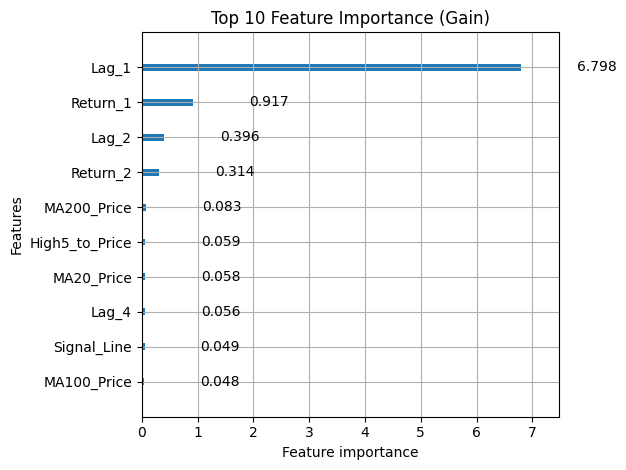

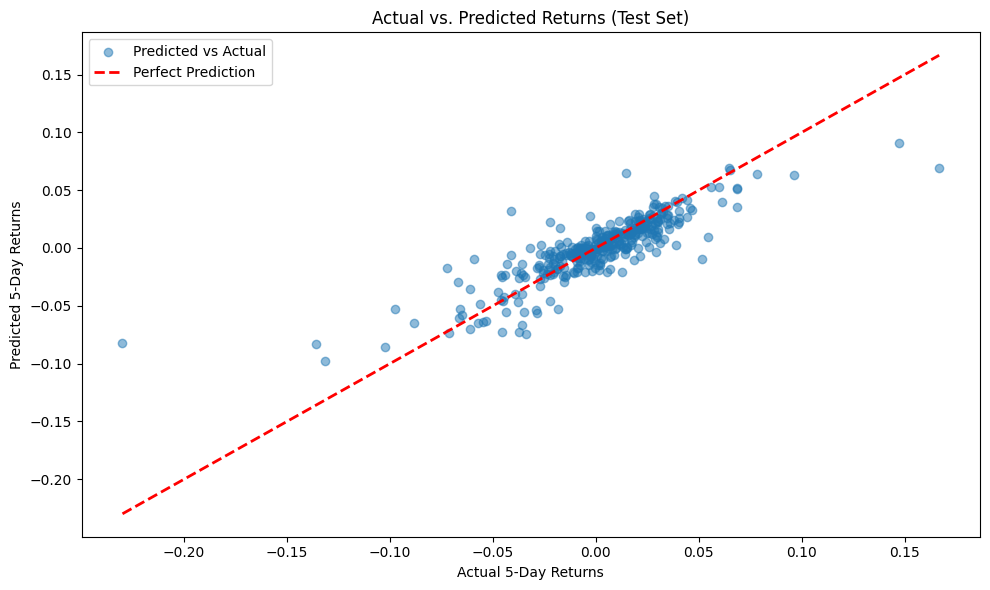

In [83]:
# Train final model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
trained_model, y_pred, scaler = train_lightgbm(X_train_scaled, y_train, X_test_scaled, y_test, feature_columns)

# --- Visualization 1: Feature Importance Plot ---
plt.figure(figsize=(10, 6))
lgb.plot_importance(trained_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importance (Gain)")
plt.tight_layout()
plt.show()


# --- Visualization 2: Actual vs. Predicted Values ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual 5-Day Returns")
plt.ylabel("Predicted 5-Day Returns")
plt.title("Actual vs. Predicted Returns (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

In [85]:
from datetime import datetime, timedelta

# Fetch latest data
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=500)).strftime('%Y-%m-%d')  # Extended for lags and features
data_etf = yf.download("XLF", start=start_date, end=end_date).reset_index()
data_sp500 = yf.download("^GSPC", start=start_date, end=end_date).reset_index()

# Compute features
df_features_latest = compute_features(data_etf, data_sp500)

# Add lagged features using historical 5-day returns
df_latest = df_features_latest.copy()
future_return = df_latest['PriceXLF'].pct_change(5).shift(-5)  # Historical returns
df_latest['Target'] = future_return
for lag in range(1, 6):
    df_latest[f'Lag_{lag}'] = df_latest['Target'].shift(lag)
df_latest = df_latest.replace([np.inf, -np.inf], np.nan).dropna()


# Debugging: Check columns
print("Training feature columns:", df_features.columns.tolist())
print("Latest feature columns:", df_latest.columns.tolist())
print("Requested feature columns:", feature_columns)

# Preprocess for prediction
def preprocess_for_prediction(df, scaler, feature_columns):
    latest_data = df.tail(1).copy()  # Most recent row with lags
    X_latest = latest_data[feature_columns]
    X_latest_scaled = scaler.transform(X_latest)
    return X_latest_scaled

X_latest_scaled = preprocess_for_prediction(df_latest, scaler, feature_columns)

# Predict
model = trained_model
predicted_return = model.predict(X_latest_scaled)[0]
print(f"Predicted 5-day return for XLF starting {end_date}: {predicted_return * 100:.2f}%")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Training feature columns: ['PriceXLF', 'sp500price', 'Return_1', 'Return_2', 'Return_3', 'Return_4', 'Return_5', 'RSI_6', 'RSI_12', 'RSI_24', 'MA20_Price', 'MA20_Bigger', 'MA50_Price', 'MA50_Bigger', 'MA100_Price', 'MA100_Bigger', 'MA200_Price', 'MA200_Bigger', 'SP500_5Day_Mean_Return', 'MACD', 'Signal_Line', 'MACD_Histogram', 'High20_to_Price', 'Low20_to_Price', 'High5_to_Price', 'Low5_to_Price', 'Target']
Latest feature columns: ['PriceXLF', 'sp500price', 'Return_1', 'Return_2', 'Return_3', 'Return_4', 'Return_5', 'RSI_6', 'RSI_12', 'RSI_24', 'MA20_Price', 'MA20_Bigger', 'MA50_Price', 'MA50_Bigger', 'MA100_Price', 'MA100_Bigger', 'MA200_Price', 'MA200_Bigger', 'SP500_5Day_Mean_Return', 'MACD', 'Signal_Line', 'MACD_Histogram', 'High20_to_Price', 'Low20_to_Price', 'High5_to_Price', 'Low5_to_Price', 'Target', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']
Requested feature columns: ['Return_1', 'Return_2', 'Return_3', 'Return_4', 'Return_5', 'RSI_6', 'RSI_12', 'RSI_24', 'MA20_Price', 'MA2